In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.io import loadmat, savemat
from scipy import signal
from tqdm import tqdm
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

(1, 2)
0 procedures (from 1) were skipped!


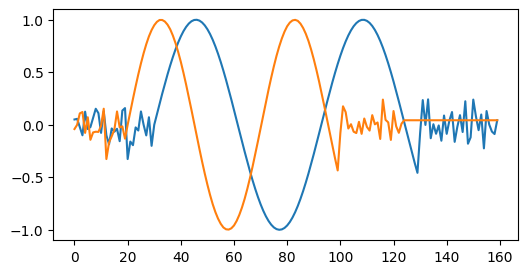

In [5]:
from misc.Sergei_scalings import shift_scale_sample_4d, align_tensor_by_se

sample = np.concatenate([np.random.randn(30)/10,np.sin(np.arange(100)/10), np.random.randn(30)/10])

new_sample = align_tensor_by_se(sample.reshape(1,-1,1), [[30,130]], s_e_new=[20, 100], filling='fl')

plt.figure(figsize=(6,3))
plt.plot(sample)
plt.plot(new_sample[0,::,0])
plt.show()

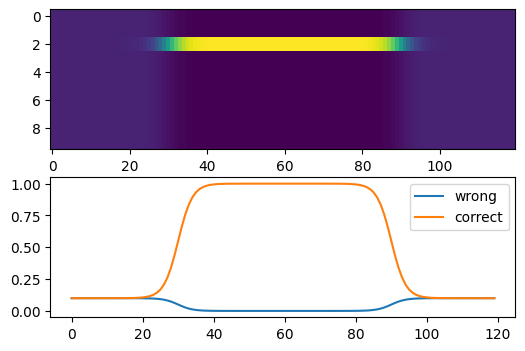

In [6]:
from misc.Probability_curve import generate_bell

prob = generate_bell(N_tags=10, N_time_frames=120, cur_tag=2, start=30, stop=90)

fig, axs = plt.subplots(2,1, figsize=(6,4))
axs[0].imshow(prob, aspect='auto')
axs[1].plot(prob[0], label='wrong')
axs[1].plot(prob[2], label='correct')
axs[1].legend()
plt.show()

### loading data

In [7]:
mt_file_clean = loadmat('data/ALIGNED_SER_4d_full.mat')

In [8]:
mt_file_clean.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data', 'starts', 'stops'])

In [9]:
labels_full = mt_file_clean['labels'][0]
labels_full

array([ 0,  1,  2, ..., 27, 42, 45], dtype=int64)

In [10]:
data_full = mt_file_clean['data']
data_full.shape

(7420, 120, 67, 3)

In [11]:
data_4d = data_full[::,::,::,0:2]
data_4d.shape

(7420, 120, 67, 2)

In [12]:
# scaling
data_4d = shift_scale_sample_4d(data_4d, copy_data=True, do_flip=True)
data_4d.shape

(7420, 120, 67, 2)

In [13]:
starts, stops = mt_file_clean['starts'][0], mt_file_clean['stops'][0]
(starts, stops)

(array([20., 20., 20., ..., 20., 20., 20.]),
 array([76. , 63. , 76. , ..., 73. , 77.5, 59. ]))

### Dataset preparation

In [14]:
data_3d_full = data_4d.reshape(data_4d.shape[0], data_4d.shape[1], data_4d.shape[2]*data_4d.shape[3])
data_3d_full.shape

(7420, 120, 134)

In [15]:
se = np.stack([starts, stops], axis=1)
data_3d_full = align_tensor_by_se(data_3d_full, se, s_e_new=[30, 90])

(7420, 2)
0 procedures (from 7420) were skipped!


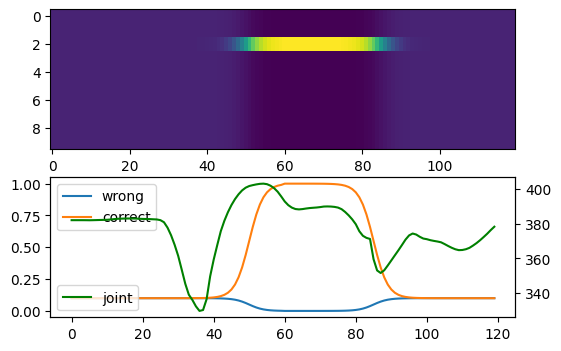

In [16]:
prob = generate_bell(N_tags=10, N_time_frames=120, cur_tag=2, start=50, stop=85)
fig, axs = plt.subplots(2,1, figsize=(6,4))
axs[0].imshow(prob, aspect='auto')
axs[1].plot(prob[0], label='wrong')
axs[1].plot(prob[2], label='correct')
# axs[1].plot(np.abs(data_3d_full).sum(-1)[2034,:]/150, label='joint')
ax2 = axs[1].twinx()
ax2.plot(np.abs(data_3d_full - data_3d_full[:, 1:5, :].sum(1, keepdims=True)).sum(-1)[200, :],
         'g', label='joint')
axs[1].legend(loc='upper left')
ax2.legend(loc='lower left')
plt.show()

In [17]:
data_3d_train, data_3d_test, labels_train, labels_test = train_test_split(data_3d_full,
                                                                          labels_full,
                                                                          test_size=0.05)

print(data_3d_train.shape)
print(data_3d_test.shape)

(7049, 120, 134)
(371, 120, 134)


### Autoencoder simple

In [18]:
# alignment

mean_init_train = np.mean(data_3d_train[::,0:5,::], axis=1)
data_3d_train_no_mean = data_3d_train - mean_init_train[:,np.newaxis]

mean_init_test = np.mean(data_3d_test[::,0:5,::], axis=1)
data_3d_test_no_mean = data_3d_test - mean_init_test[:,np.newaxis]

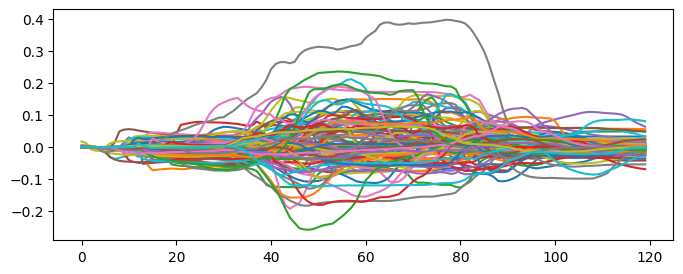

In [19]:
plt.figure(figsize=(8,3))
for i in range(100):
    plt.plot(data_3d_test_no_mean[i,::,14])
plt.show()

### Segmentation dataset

In [20]:
from torch.utils.data import Dataset, DataLoader

class Dataset_Segmentation(Dataset):
    def __init__(self, data, labels):

        self.data = data
        self.labels = labels
        self.uniq_labels = len(np.unique(self.labels))
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        gesture_seqence, label = self.data[idx], self.labels[idx]

        gesture_seqence = torch.tensor(gesture_seqence, dtype=torch.float)
        label = torch.tensor(label)
        
        return gesture_seqence, label

In [21]:
batch_size = 128

DS_TRAIN = Dataset_Segmentation(data_3d_train_no_mean[::,::,15:16], labels_train)
DL_TRAIN = DataLoader(DS_TRAIN, batch_size=batch_size, shuffle=True)

DS_TEST = Dataset_Segmentation(data_3d_test_no_mean[::,::,15:16], labels_test)
DL_TEST = DataLoader(DS_TEST, batch_size=batch_size, shuffle=False)

for x, y in DL_TRAIN:
    print(x.shape, y.shape)
    break

torch.Size([128, 120, 1]) torch.Size([128])


### Segmentation linear model

In [22]:
class AutoencoderLinear(nn.Module):
    '''simple linear autoencoder'''
    def __init__(self, n_basisc, n_embed, n_time_points, n_classes):
        super().__init__()
        # subgestures tensor
        self.basic_funcs = torch.randn(n_time_points, n_embed, n_basisc, requires_grad=True)
        # learnable weights for subgestures
        self.weights = nn.Embedding(n_classes, n_basisc, max_norm=1)
        
    def forward(self, x, true_label):
        weight = self.weights(true_label) # getting weights from true label
        approximation = self.basic_funcs @ weight.transpose(0,1) # composing predicted gesture (average)
        return approximation.transpose(0,2).transpose(1,2)

In [23]:
AL = AutoencoderLinear(n_basisc=10, n_embed=134, n_time_points=120, n_classes=54)

In [24]:
AL(x=torch.randn(3, 120, 134), true_label=torch.tensor([3,3,4])).shape

torch.Size([3, 120, 134])

In [25]:
AL = AutoencoderLinear(n_basisc=10, n_embed=1, n_time_points=120, n_classes=54)
for x, y in DL_TRAIN:
    print(x.shape, y.shape)
    res = AL(x, y)
    print(res.shape)
    break

torch.Size([128, 120, 1]) torch.Size([128])
torch.Size([128, 120, 1])


### Segmentation training

In [26]:
device= 'cpu'

In [27]:
AL = AutoencoderLinear(n_basisc=54*2, n_embed=1, n_time_points=120, n_classes=54).to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(AL.parameters(), lr=1e-3)

In [28]:
def validate_segmentation(model, dl_test, metric):
    res = []
    with torch.no_grad():
        model.eval()
        for seq, tags in dl_test:
            seq, tags = seq.to(device), tags.to(device)
            pred_seq = model(seq, tags)
            res.append(metric(pred_seq, seq).item())
    model.train(True)
    return np.mean(res)

In [29]:
mse_test_list = []
losses_list = []

for epoch in tqdm(range(50)):

    if epoch % 5 == 0:
        mse_test_list.append(validate_segmentation(AL, DL_TEST, metric=nn.MSELoss()))

    for seq, tags in DL_TRAIN:
        AL.zero_grad()
        seq, tags = seq.to(device), tags.to(device)
        B,T,C = seq.shape
        
        pred_seq = AL(seq, tags)
        reg1 = 0.1*torch.mean(torch.abs(torch.diff(AL.basic_funcs, dim=0)))
        reg2 = 1e-6*torch.norm(AL.weights.weight, 1)
        loss = loss_fn(pred_seq.view(B,-1), seq.view(B,-1)) + reg1 + reg2
        
        loss.backward()
        losses_list.append(loss.item())
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


In [661]:
reg1

tensor(0.1124, grad_fn=<MulBackward0>)

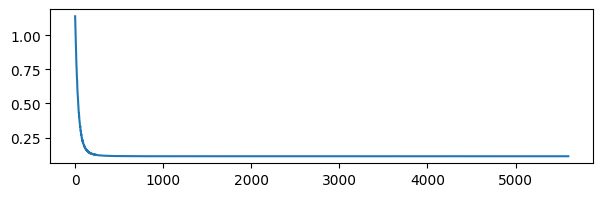

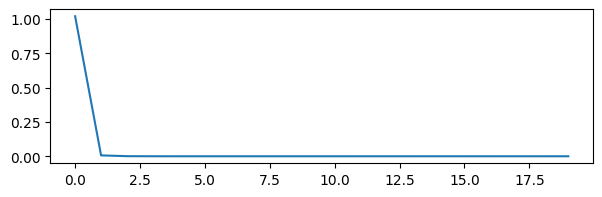

In [662]:
plt.figure(figsize=(7,2))
plt.plot(losses_list)
plt.show()

plt.figure(figsize=(7,2))
plt.plot(mse_test_list)
plt.show()

In [663]:
np.nonzero(AL.weights.weight.detach().numpy()[15] > 0.001)

(array([  0,   2,   3,   4,   5,   6,   7,   8,  14,  17,  20,  21,  22,
         24,  30,  34,  38,  39,  40,  41,  49,  53,  54,  55,  57,  61,
         62,  63,  64,  65,  66,  70,  71,  73,  75,  76,  80,  82,  85,
         86,  87,  88,  89,  93,  94,  96,  97,  99, 101, 104, 106, 107,
        108, 109, 122, 123, 124, 125, 127, 130, 131, 138, 141, 142, 143,
        144, 150, 152, 154, 156, 157, 158, 159, 160], dtype=int64),)

(120, 1, 162)


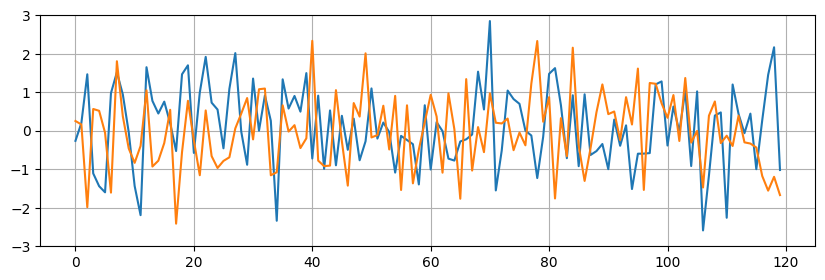

In [664]:
bsc_funcs = AL.basic_funcs.detach().numpy()
print(bsc_funcs.shape)

plt.figure(figsize=(10,3))
# plt.plot(bsc_funcs[::,0,0])
plt.plot(bsc_funcs[::,0,2])
plt.plot(bsc_funcs[::,0,8])
# plt.plot(bsc_funcs[::,0,25])
# plt.plot(bsc_funcs[4,0,::])
plt.ylim(-3,3)
plt.grid(True)
plt.show()

In [665]:
w = AL.weights.weight.detach().numpy()
w.shape

(54, 162)

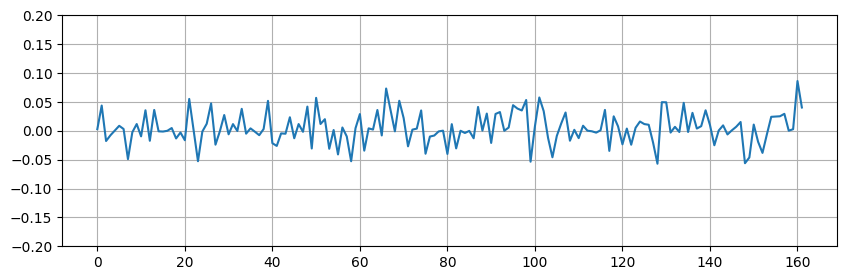

In [667]:
GESTURE = 16

plt.figure(figsize=(10,3))
plt.plot(w[GESTURE])
plt.ylim(-0.2,0.2)
plt.grid(True)
plt.show()

In [668]:
r = bsc_funcs @ w[GESTURE]
r.shape

(120, 1)

In [669]:
gstrs = data_3d_train_no_mean[labels_train==GESTURE]

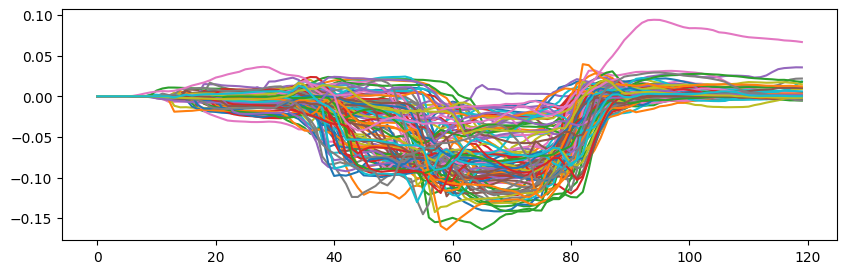

In [670]:
plt.figure(figsize=(10,3))
for i in range(100):    
    plt.plot(gstrs[i,::,15])
plt.show()

In [671]:
np.linalg.norm(r - gstrs[24,::,15:16])

0.11969525446228486

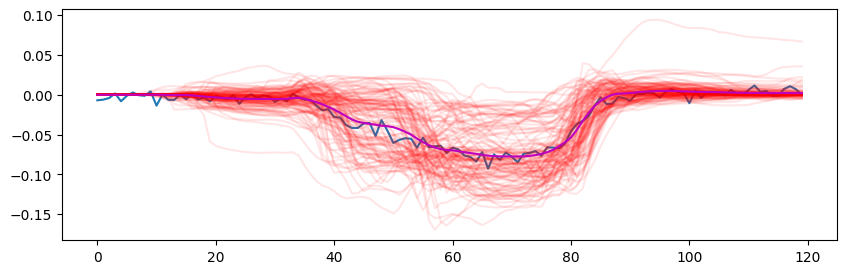

In [672]:
plt.figure(figsize=(10,3))
JNT = 0

# plt.fi
plt.plot(r[::,JNT])
for i in range(gstrs.shape[0]):
    plt.plot(gstrs[i,::,15], 'r', alpha=0.1)
    
plt.plot(np.mean(gstrs[::,::,15], axis=0), 'm')
plt.show()

In [558]:
bsc_funcs.shape

(120, 1, 270)

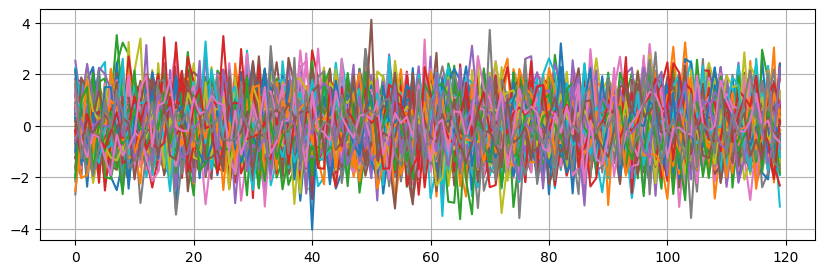

In [559]:
plt.figure(figsize=(10,3))

w1 = w[GESTURE]
for i in np.nonzero(w1>0.01):
    plt.plot(bsc_funcs[::,0,i])
plt.grid(True)
plt.show()

In [40]:
X = data_3d_train_no_mean[::,::,15]
X.shape

(7049, 120)

In [36]:
from hmmlearn import hmm

In [42]:
hmm.GaussianHMM??

In [41]:
model2 = hmm.GaussianHMM(1, "full")

model2.fit([X[0]]) 

Fitting a model with 7380 free scalar parameters with only 120 data points will result in a degenerate solution.
C:\Users\79219\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\hmmlearn\hmm.py:305: RuntimeWarning: Degrees of freedom <= 0 for slice
  cv = np.cov(X.T) + self.min_covar * np.eye(X.shape[1])
C:\Users\79219\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\79219\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: component 0 of 'full' covars must be symmetric, positive-definite